In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

from skimage.filters import threshold_otsu

In [2]:
import os
import cv2
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [3]:
import torch
from torchvision import datasets

In [4]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/data/mnist_split/test_mnist.pkl', "rb") as f:
    test_set = pickle.load(f)

In [5]:
test_set = [((pair[1] > 127).view(np.uint8) * 255, (pair[0] > 127).view(np.uint8) * 255) for pair in test_set]

In [6]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [7]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [8]:
import time

dice_scores = []
mse_scores = []

registered_images = []

start_time = time.time()
for idx, (source_image, target_image) in tqdm(enumerate(test_set)):

    v, u = optical_flow_tvl1(target_image, source_image, num_iter=100)

    nr, nc = target_image.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    source_image_warp = warp(source_image, np.array([row_coords + v, col_coords + u]), mode='edge')

    registered_images.append(source_image_warp)

    source_image_warp_float = source_image_warp.astype(np.float64) / 255.0
    target_float = target_image.astype(np.float64) / 255.0

    dice = dice_score(source_image_warp_float, target_float)
    mse = mean_squared_error(source_image_warp_float, target_float)

    dice_scores.append(dice)
    mse_scores.append(mse)    

end_time = time.time() - start_time
print(end_time)

0it [00:00, ?it/s]

542it [01:05,  8.23it/s]

65.89881992340088


In [9]:
metrics_data = pd.DataFrame({
    'dice': dice_scores,
    'mse': mse_scores
})

In [10]:
metrics_data

,dice,mse
0,0.748466,0.110397
1,0.905660,0.102674
2,0.905350,0.157142
3,0.934783,0.111457
4,0.797619,0.117974
...,...,...
537,0.768559,0.173980
538,0.732026,0.092593
539,0.820276,0.135640
540,0.902326,0.130444


In [11]:
metrics_data['dice'].mean()

0.791743725353892

In [12]:
metrics_data['mse'].mean()

0.12723073642317187

In [13]:
metrics_data.to_csv('/Users/nastya/Documents/ucu/thesis/optical_flow/mnist/metrics.csv')

In [14]:
import pickle

with open('/Users/nastya/Documents/ucu/thesis/optical_flow/mnist/registered.pkl', 'wb') as f:
    pickle.dump(registered_images, f)

Text(0.5, 1.0, 'Moving Image')

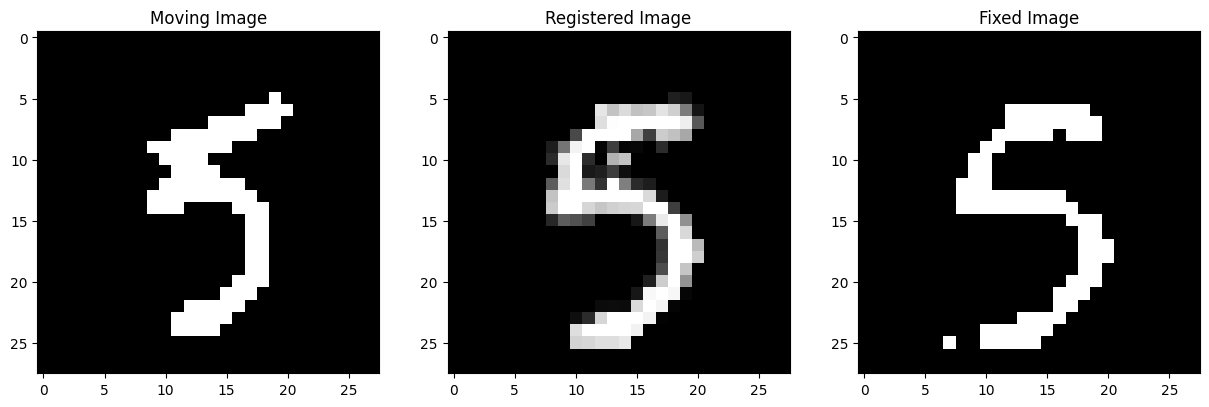

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[3],cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(test_set[3][1],cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(test_set[3][0],cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

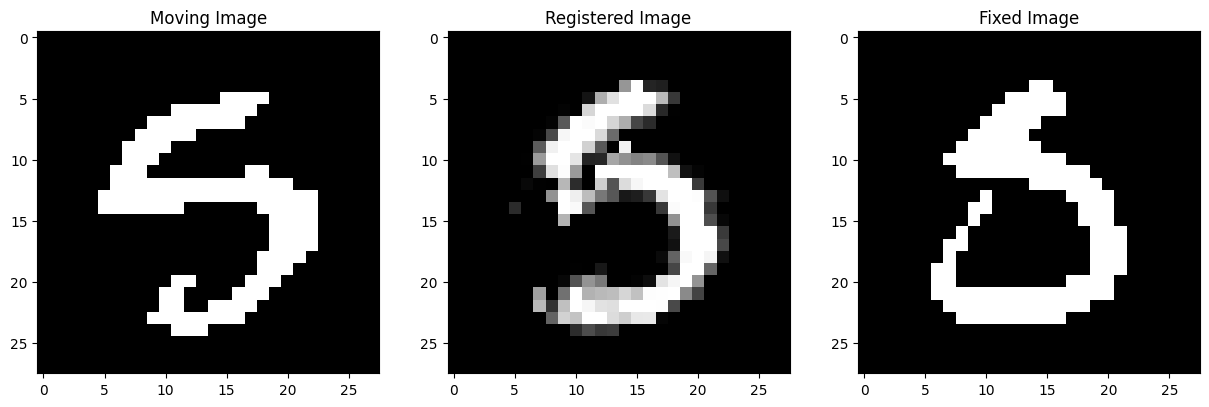

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[78],cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(test_set[78][1],cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(test_set[78][0],cmap='gray', interpolation='none')
plt.title("Moving Image")

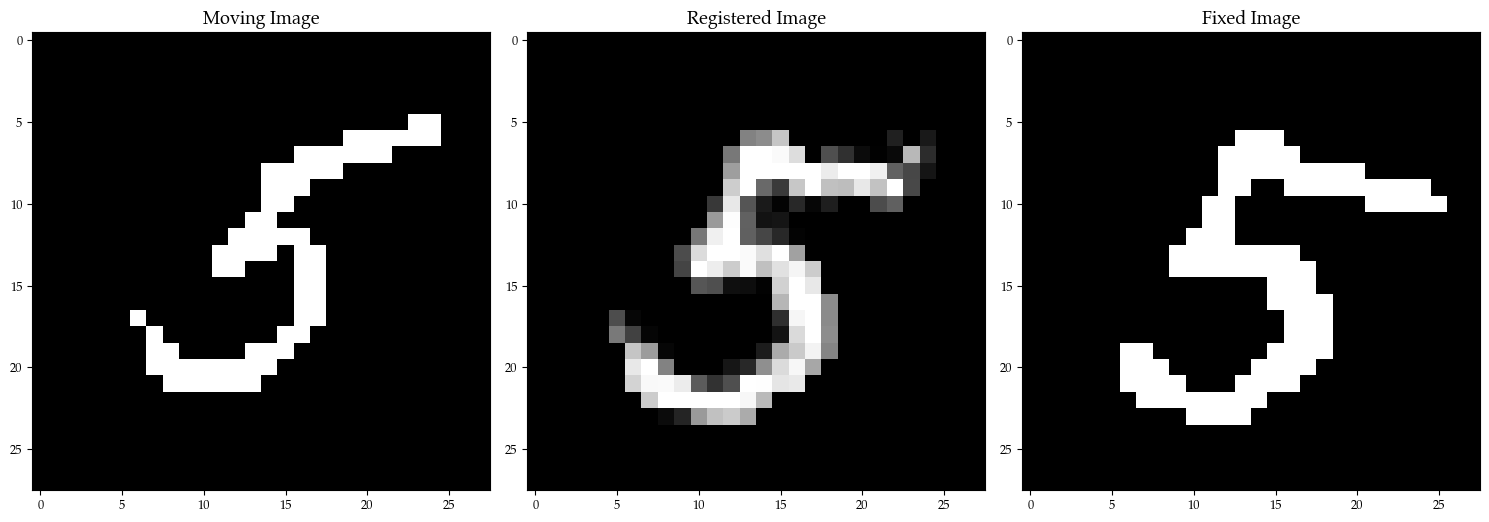

In [56]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[101] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[101][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[101][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

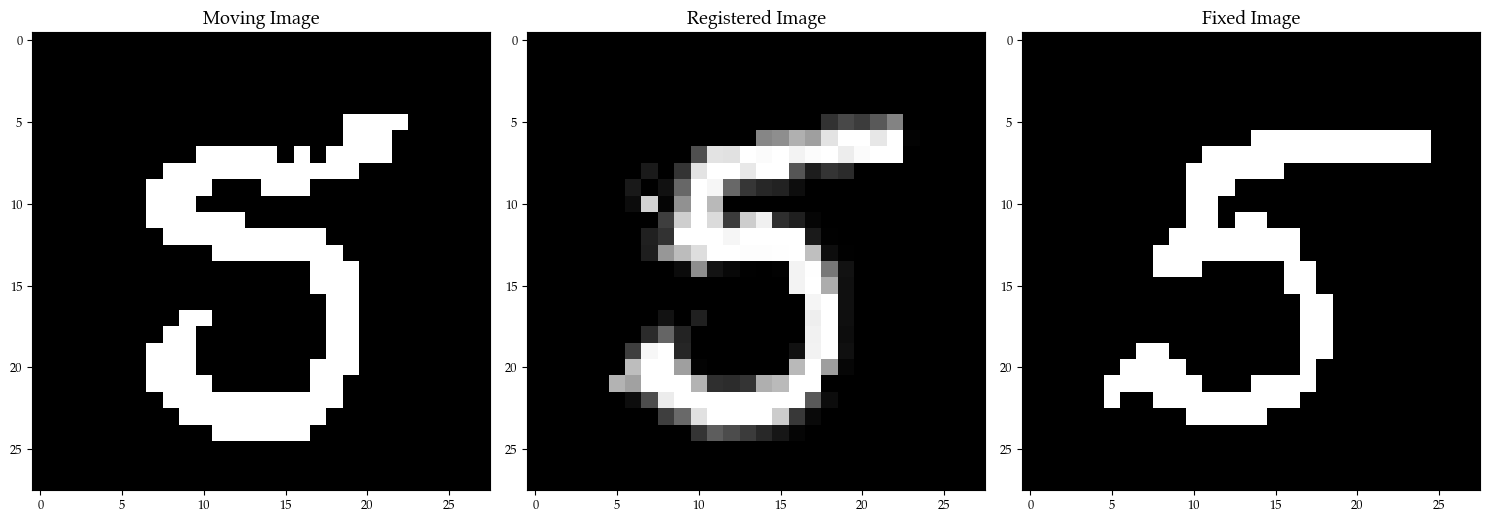

In [57]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[123] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[123][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[123][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

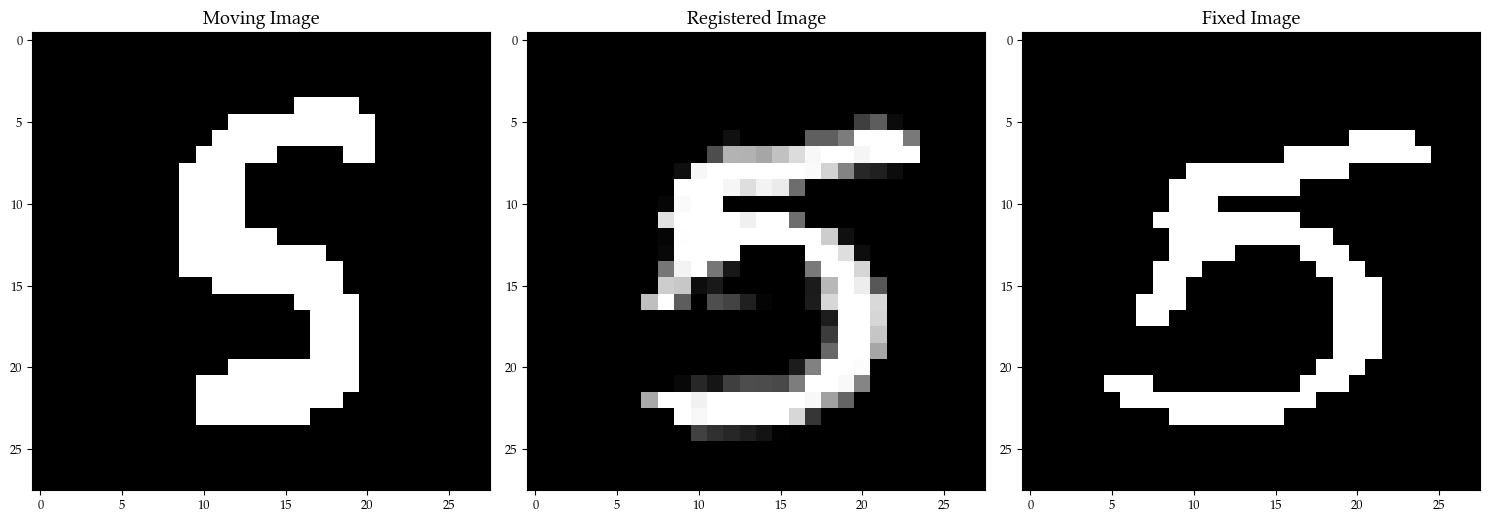

In [58]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered_images[65] ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(test_set[65][1] ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(test_set[65][0] ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()